<a href="https://colab.research.google.com/github/WouterNoordhof/NotS-P-Stofzuiger/blob/master/CaptchaSolver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOTE: to obtain the most recent version of this notebook, please copy from 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1aVo6-YYXqB14Abvwpygj57HfzqcV3f-o#scrollTo=lsT4-_Eq45Ww&uniqifier=1)


## **Training Faster R-CNN Object Detection on a Custom Dataset**

### **Overview**

The code in this notebook is very similar to the one about cell detection. However we have made changes to it to also be able to solve the CAPTCHA's from Sci-Hub.

![Example](https://raw.githubusercontent.com/WouterNoordhof/captcha-data/master/images/train/5e95917187185.jpg)

The application uses a faster R-CNN object detection model, using the TensorFlow Object Detection API.


**Credit to [DLology](https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/) and [Tony607](https://github.com/Tony607)**, whom wrote the first notebook on which much of this is example is based. 








In [0]:
# This whole notebook can't run in one session.
# Probably because of code blocks still running but mentioned as completed by the kernel
# Hacking with timers is a valid but stupid solution

import time
from datetime import datetime

In [0]:
# # Install the PyDrive wrapper & import libraries.
# # This only needs to be done once in a notebook.
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [0]:
!pip install tensorflow_gpu==1.15

In [0]:
startTime = datetime.now()
!pip show tensorflow
print ("##### Duration: ", datetime.now() - startTime)

Name: tensorflow
Version: 2.2.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: tensorboard, opt-einsum, keras-preprocessing, astunparse, h5py, six, scipy, absl-py, google-pasta, numpy, wheel, grpcio, wrapt, tensorflow-estimator, gast, termcolor, protobuf
Required-by: fancyimpute
##### Duration:  0:00:04.155666


In [0]:
startTime = datetime.now()
!pip show tensorflow-gpu
print ("##### Duration: ", datetime.now() - startTime)

Name: tensorflow-gpu
Version: 1.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: google-pasta, keras-applications, gast, tensorboard, tensorflow-estimator, astor, termcolor, wheel, grpcio, absl-py, opt-einsum, keras-preprocessing, wrapt, numpy, protobuf, six
Required-by: 
##### Duration:  0:00:03.614871


## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [0]:
startTime = datetime.now()
# If you forked the repo, you can replace the link.
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = 10000  # 200000 to improve

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
#selected_model = 'faster_rcnn_inception_v2'
selected_model = 'rfcn_resnet101'


# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colab's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

print ("##### Duration: ", datetime.now() - startTime )

##### Duration:  0:00:00.000227


## Clone the `tensorflow-object-detection` repository or your fork.

In [0]:
startTime = datetime.now()
import os

%cd /content
!rm -fr /content/tensorflow-object-detection-faster-rcnn

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull
print ("##### Duration: ", datetime.now() - startTime )

/content
Cloning into 'tensorflow-object-detection-faster-rcnn'...
remote: Enumerating objects: 885, done.
remote: Total 885 (delta 0), reused 0 (delta 0), pack-reused 885
Receiving objects: 100% (885/885), 24.84 MiB | 18.59 MiB/s, done.
Resolving deltas: 100% (418/418), done.
/content/tensorflow-object-detection-faster-rcnn
Already up to date.
##### Duration:  0:00:08.596304


In [0]:
time.sleep(10)

## Install required packages

In [0]:
startTime = datetime.now()
%cd /content
!rm -fr /content/models
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools #pip install git+https://github.com/philferriere/cocoapi.git#egg=pycocotools^&subdirectory=PythonAPI

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

# make sure to first run `python setup.py build` and `python setup.py install` if you want to make this a local project

!python object_detection/builders/model_builder_test.py
print ("##### Duration: ", datetime.now() - startTime )

/content
/content/models/research
object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.
##### Duration:  0:00:41.351170


In [0]:
time.sleep(10)

## Prepare `tfrecord` files

Roboflow automatically creates our TFRecord and label_map files that we need!

**Generating your own TFRecords the only step you need to change for your own custom dataset.**

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [0]:
startTime = datetime.now()
%mkdir -p /content/tensorflow-object-detection-faster-rcnn/images
%cd /content/tensorflow-object-detection-faster-rcnn/
!pwd
print ("##### Duration: ", datetime.now() - startTime)

/content/tensorflow-object-detection-faster-rcnn
/content/tensorflow-object-detection-faster-rcnn
##### Duration:  0:00:03.851940


In [0]:
startTime = datetime.now()

!rm -fr images*
# UPDATE THIS LINK
!curl -L https://github.com/WouterNoordhof/captcha-data/archive/master.zip > images.zip; 
!unzip images.zip && mv captcha-data-master images-master
#!curl -L https://gitlab.com/theotheu/images/-/archive/master/images-master.zip > images.zip

print ("##### Duration: ", datetime.now() - startTime)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   132  100   132    0     0    602      0 --:--:-- --:--:-- --:--:--   600
100  206M    0  206M    0     0  20.8M      0 --:--:--  0:00:09 --:--:-- 22.3M
Archive:  images.zip
70092f7b676e7951118d972001fd3d7d1cef25b9
   creating: captcha-data-master/
  inflating: captcha-data-master/.gitignore  
   creating: captcha-data-master/data/
 extracting: captcha-data-master/data/.gitkeep  
  inflating: captcha-data-master/data/character_labels_test.csv  
  inflating: captcha-data-master/data/character_labels_train.csv  
  inflating: captcha-data-master/data/label_map.pbtxt  
  inflating: captcha-data-master/data/test.record  
  inflating: captcha-data-master/data/train.record  
   creating: captcha-data-master/images/
  inflating: captcha-data-master/images/5e9514d5eb10d.jpg  
  inflating: captcha-data-master/images/5e9514d5eb10d.xml  

In [0]:
time.sleep(10)

In [0]:
%%bash
ls -l images-master/images/test|wc -l

136


In [0]:
%%bash
SECONDS=0
pwd
mkdir -p images/train; mkdir -p images/test;  mkdir -p images/validate; mkdir -p data
cp -fr images-master/images/test/* images/test
cp -fr images-master/images/train/* images/train
cp -fr images-master/images/validate/* images/validate
cp -fr images-master/data/* data
#rm -rf images-master; rm -fr images.zip
ELAPSED="Elapsed: $(($SECONDS / 3600))hrs $((($SECONDS / 60) % 60))min $(($SECONDS % 60))sec"
echo $ELAPSED

/content/tensorflow-object-detection-faster-rcnn
Elapsed: 0hrs 0min 0sec


In [0]:
%%bash
ls -l /content/tensorflow-object-detection-faster-rcnn/images

total 156
drwxr-xr-x 2 root root  12288 Jun  6 14:55 test
drwxr-xr-x 2 root root 126976 Jun  6 14:55 train
drwxr-xr-x 2 root root  16384 Jun  6 14:55 validate


In [0]:
%ls /content/tensorflow-object-detection-faster-rcnn/images/test | wc -l

135


In [0]:
%ls -l data

total 42816
-rw-r--r-- 1 root root    24097 Jun  6 14:55 character_labels_test.csv
-rw-r--r-- 1 root root   506704 Jun  6 14:55 character_labels_train.csv
-rw-r--r-- 1 root root       58 Jun  6 14:53 FYI.txt
-rw-r--r-- 1 root root     1291 Jun  6 14:55 label_map.pbtxt
-rw-r--r-- 1 root root  2693071 Jun  6 14:55 test.record
-rw-r--r-- 1 root root 40605392 Jun  6 14:55 train.record


In [0]:
%ls -l /content/tensorflow-object-detection-faster-rcnn/images

total 156
drwxr-xr-x 2 root root  12288 Jun  6 14:55 test/
drwxr-xr-x 2 root root 126976 Jun  6 14:55 train/
drwxr-xr-x 2 root root  16384 Jun  6 14:55 validate/


In [0]:
# import os
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = "/content/gdrive/My Drive"
# base_dir = root_dir + '/sci-hub-captcha-solver'
# image_dir = base_dir + "/images"

In [0]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/test.record'
train_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train.record'
label_map_pbtxt_fname = '/content/tensorflow-object-detection-faster-rcnn/data/label_map.pbtxt'

## Download base model

In [0]:
print ("##### MODEL", MODEL)



##### MODEL rfcn_resnet101_coco_2018_01_28


In [0]:
#@title
startTime = datetime.now()
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = ' http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)
print ("##### Duration: ", datetime.now() - startTime)

/content/models/research
##### Duration:  0:00:11.495959


In [0]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 476M
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 .
drwxr-xr-x 63 root   root 4.0K Jun  6 14:55 ..
-rw-r--r--  1 345018 5000   77 Feb  1  2018 checkpoint
-rw-r--r--  1 345018 5000 208M Feb  1  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 5000 262M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 5000  26K Feb  1  2018 model.ckpt.index
-rw-r--r--  1 345018 5000 6.4M Feb  1  2018 model.ckpt.meta
-rw-r--r--  1 345018 5000 3.1K Feb  1  2018 pipeline.config
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 saved_model


In [0]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [0]:
startTime = datetime.now()
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)
print ("##### pipeline_fname:", pipeline_fname)
assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)
print ("##### Duration: ", datetime.now() - startTime)

##### pipeline_fname: /content/models/research/object_detection/samples/configs/rfcn_resnet101_pets.config
##### Duration:  0:00:00.001531


In [0]:
startTime = datetime.now()

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
print ("##### Duration: ", datetime.now() - startTime)    

##### Duration:  0:00:00.000116


In [0]:
time.sleep(10)

In [0]:
startTime = datetime.now()
import re
!ls /content/tensorflow-object-detection-faster-rcnn/data/label_map.pbtxt
num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

print ("##### Duration: ", datetime.now() - startTime) 

/content/tensorflow-object-detection-faster-rcnn/data/label_map.pbtxt
##### Duration:  0:00:03.060370


In [0]:
startTime = datetime.now()
!cat {pipeline_fname}
print ("##### Duration: ", datetime.now() - startTime)

# R-FCN with Resnet-101 (v1),  configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 26
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet101'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncate

In [0]:
startTime = datetime.now()

model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

print ("##### model_dir:", model_dir)

%ls -l training
print ("##### Duration: ", datetime.now() - startTime)

##### model_dir: training/
total 0
##### Duration:  0:00:03.174277


## Run Tensorboard(Optional)

In [0]:
startTime = datetime.now()

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

print ("##### Duration: ", datetime.now() - startTime)

--2020-06-06 14:56:05--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.20.123.149, 34.235.94.90, 18.232.237.110, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.20.123.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  12.2MB/s    in 1.1s    

2020-06-06 14:56:07 (12.2 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
##### Duration:  0:00:04.483816


In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
startTime = datetime.now()
get_ipython().system_raw('./ngrok http 6006 &')
print ("##### Duration: ", datetime.now() - startTime)

##### Duration:  0:00:00.024960


### Get Tensorboard link

In [0]:
startTime = datetime.now()

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
print ("##### Duration: ", datetime.now() - startTime)    

https://eaecbb8e2a17.ngrok.io
##### Duration:  0:00:01.429090


## Train the model

In [0]:
# Variables in calling model_main.py
print ("##### pipeline_fname: ", pipeline_fname)
print ("##### model_dir: ", model_dir)
print ("##### num_steps: ", num_steps)
print ("##### num_eval_steps: ", num_eval_steps)

##### pipeline_fname:  /content/models/research/object_detection/samples/configs/rfcn_resnet101_pets.config
##### model_dir:  training/
##### num_steps:  10000
##### num_eval_steps:  50


In [0]:
time.sleep(10)

In [0]:
!pip install tf_slim

In [0]:
startTime = datetime.now()

!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

print ("##### Duration: ", datetime.now() - startTime)

W0606 14:56:28.753529 140431368050560 model_lib.py:717] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 10000
I0606 14:56:28.753796 140431368050560 config_util.py:523] Maybe overwriting train_steps: 10000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0606 14:56:28.753983 140431368050560 config_util.py:523] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0606 14:56:28.754159 140431368050560 config_util.py:523] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0606 14:56:28.754298 140431368050560 config_util.py:523] Maybe overwriting eval_num_epochs: 1
INFO:tensorflow:Maybe overwriting load_pretrained: True
I0606 14:56:28.754431 140431368050560 config_util.py:523] Maybe overwriting load_pretrained: True
INFO:tensorflow:Ignoring config override key: load_pretrained
I0606 14:56:28.754562 140431368050560 config_util.py

In [0]:
time.sleep(10)

In [0]:
!ls {model_dir}

checkpoint				     model.ckpt-0.meta
events.out.tfevents.1591455453.611ae3d1dfb6  model.ckpt-306.data-00000-of-00001
graph.pbtxt				     model.ckpt-306.index
model.ckpt-0.data-00000-of-00001	     model.ckpt-306.meta
model.ckpt-0.index


## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [0]:
!pwd

/content/models/research


In [0]:
startTime = datetime.now()
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

print ("##### Duration: ", datetime.now() - startTime)    

training/model.ckpt-306
INFO:tensorflow:Scale of 0 disables regularizer.
I0606 15:09:09.807673 140609061787520 regularizers.py:99] Scale of 0 disables regularizer.
Instructions for updating:
Please use `layer.__call__` method instead.
W0606 15:09:09.811277 140609061787520 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Scale of 0 disables regularizer.
I0606 15:09:13.758510 140609061787520 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
I0606 15:09:13.776129 140609061787520 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0606 15:09:13.776519 140609061787520 convolutional_box_predictor.py:156] depth of additional conv b

In [0]:
time.sleep(10)

In [0]:
print ("##### output_directory", output_directory)
!ls -l /content/models/research/fine_tuned_model
!ls {output_directory}

##### output_directory ./fine_tuned_model
total 459092
-rw-r--r-- 1 root root        77 Jun  6 15:09 checkpoint
-rw-r--r-- 1 root root 204081510 Jun  6 15:09 frozen_inference_graph.pb
-rw-r--r-- 1 root root 262621844 Jun  6 15:09 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root     25844 Jun  6 15:09 model.ckpt.index
-rw-r--r-- 1 root root   3359209 Jun  6 15:09 model.ckpt.meta
-rw-r--r-- 1 root root      3219 Jun  6 15:09 pipeline.config
drwxr-xr-x 3 root root      4096 Jun  6 15:09 saved_model
checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


## Download the model `.pb` file

In [0]:
startTime = datetime.now()
import os

pb_fname = os.path.join(os.path.abspath('/content/models/research/fine_tuned_model/'), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

print ("##### output_directory: ", output_directory)
print ("##### Duration: ", datetime.now() - startTime)

##### output_directory:  ./fine_tuned_model
##### Duration:  0:00:00.000715


In [0]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 195M Jun  6 15:09 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


### Option1 : upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [0]:
# startTime = datetime.now()
# !cp /content/models/research/fine_tuned_model/frozen_inference_graph.pb /content/tensorflow-object-detection-faster-rcnn/data/frozen_inference_graph.pb
# !ls -l /content/tensorflow-object-detection-faster-rcnn/data/frozen_inference_graph.pb
# print ("##### Duration: ", datetime.now() - startTime)
# # Next step not required

In [0]:
# startTime = datetime.now()

# # Install the PyDrive wrapper & import libraries.
# # This only needs to be done once in a notebook.
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials


# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# fname = os.path.basename(pb_fname)
# print ("##### pb_fname: ", pb_fname)
# print ("##### fname: ", fname)
# # Create & upload a text file.
# uploaded = drive.CreateFile({'title': fname})
# uploaded.SetContentFile(pb_fname)
# !cp /content/models/research/fine_tuned_model/frozen_inference_graph.pb /content/tensorflow-object-detection-faster-rcnn/data/frozen_inference_graph.pb
# !ls -l /content/tensorflow-object-detection-faster-rcnn/data/frozen_inference_graph.pb
# # uploaded.Upload()
# # print('Uploaded file with ID {}'.format(uploaded.get('id')))
# print ("##### fname: ", fname)
# print ("##### Duration: ", datetime.now() - startTime)

### Option2 :  Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [0]:
# from google.colab import files
# files.download(pb_fname)
# print ("##### pb_fname: ", pb_fname)

### OPTIONAL: Download the `label_map.pbtxt` file

In [0]:
# from google.colab import files
# files.download(label_map_pbtxt_fname)
# print ("##### label_map_pbtxt_fname: ", label_map_pbtxt_fname)

### OPTIONAL: Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [0]:
# startTime = datetime.now()
# from google.colab import files
# files.download(pipeline_fname)
# print ("##### pipeline_fname", pipeline_fname)
# print ("##### Duration: ", datetime.now() - startTime)

In [0]:
time.sleep(5)

In [0]:
# !tar cfz fine_tuned_model.tar.gz fine_tuned_model
# from google.colab import files
# files.download('fine_tuned_model.tar.gz')

## Run inference test

To test on your own images, you need to upload raw test images to the `test` folder located inside `/data`.

Right now, this folder contains TFRecord files from Roboflow. We need the raw images.


#### Add test images to this notebook

We can download the exact same raw images that are in our Roboflow test split to our local computer by downloading the images in a different (non-TFRecord) format.

Go back to our [dataset](https://public.roboflow.ai/object-detection/bccd/1), click "Download," select "COCO JSON" as the format, and download to your local machine.

Unzip the downloaded file, and navigate to the `test` directory.
![folder](https://i.imgur.com/xkjxmKP.png)


Now, on the left-hand side in the colab notebook, select the folder icon.
![Colab folder](https://i.imgur.com/59v08qG.png)

Right-click on `test`, and select "Upload." Navigate to the files locally on your machine you just downloaded...and voila! You're set!


In [0]:
%%bash

ls -l /content/tensorflow-object-detection-faster-rcnn/images/test

total 10308
-rw-r--r-- 1 root root 54846 Jun  6 14:55 5e9547cf1f91a_jpg.rf.f0f1f4b585e6d07943f28fab3b708006.jpg
-rw-r--r-- 1 root root 54435 Jun  6 14:55 5e956738813c3_jpg.rf.4705a79d7b1be407c272a822cf3942ab.jpg
-rw-r--r-- 1 root root 54655 Jun  6 14:55 5e95a007196a9_jpg.rf.e99c7a232b75beb1291730f958b51ad0.jpg
-rw-r--r-- 1 root root 54199 Jun  6 14:55 5e95a12743efc_jpg.rf.b66613dd20528072525e73cda3cc622f.jpg
-rw-r--r-- 1 root root 54878 Jun  6 14:55 5e95a24576c5e_jpg.rf.a3d8512e21bb432cec57966ad5fa54f9.jpg
-rw-r--r-- 1 root root 87488 Jun  6 14:55 5e95a2764db4a.jpg
-rw-r--r-- 1 root root 54155 Jun  6 14:55 5e95a28943313_jpg.rf.df0035a659c4b22c7a95d58827dfcb5b.jpg
-rw-r--r-- 1 root root 86538 Jun  6 14:55 5e95a3f2d353d.jpg
-rw-r--r-- 1 root root 87431 Jun  6 14:55 5e95a4679172c.jpg
-rw-r--r-- 1 root root 86943 Jun  6 14:55 5e95a835809b8.jpg
-rw-r--r-- 1 root root 87554 Jun  6 14:55 5e95a8500dfd4.jpg
-rw-r--r-- 1 root root 87395 Jun  6 14:55 5e95a8560163a.jpg
-rw-r--r-- 1 root root 54381

In [0]:
# optionally, remove the TFRecord and cells_label_map.pbtxt from
# the test directory so it is only raw images
%pwd
print (repo_dir_path)
%cd {repo_dir_path}
%cd data/test
%rm cells.tfrecord
%rm cells_label_map.pbtxt

/content/tensorflow-object-detection-faster-rcnn
/content/tensorflow-object-detection-faster-rcnn
[Errno 2] No such file or directory: 'data/test'
/content/tensorflow-object-detection-faster-rcnn
rm: cannot remove 'cells.tfrecord': No such file or directory
rm: cannot remove 'cells_label_map.pbtxt': No such file or directory


In [0]:
print ("##### label_map_pbtxt_fname", label_map_pbtxt_fname)
print ("##### pb_fname", pb_fname)


##### label_map_pbtxt_fname /content/tensorflow-object-detection-faster-rcnn/data/label_map.pbtxt
##### pb_fname /content/models/research/fine_tuned_model/frozen_inference_graph.pb


In [0]:
startTime = datetime.now()

import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
#PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "data/test")
PATH_TO_TEST_IMAGES_DIR =  os.path.join("/content/tensorflow-object-detection-faster-rcnn/images/test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

print ("##### Duration: ", datetime.now() - startTime)


['/content/tensorflow-object-detection-faster-rcnn/images/test/angled.jpg', '/content/tensorflow-object-detection-faster-rcnn/images/test/5e95bb6362868_jpg.rf.320f5c77a89f8c7b1b71d65ea71c3d11.jpg', '/content/tensorflow-object-detection-faster-rcnn/images/test/5e95ba33b6020_jpg.rf.fd6ac7bb341db1f804932d202cbc172b.jpg', '/content/tensorflow-object-detection-faster-rcnn/images/test/5e95abd52bb96.jpg', '/content/tensorflow-object-detection-faster-rcnn/images/test/aivers.jpg', '/content/tensorflow-object-detection-faster-rcnn/images/test/5e95bf78a0359_jpg.rf.5612a2e718b12a0f6baaf44b36990411.jpg', '/content/tensorflow-object-detection-faster-rcnn/images/test/5e95b1859bd92.jpg', '/content/tensorflow-object-detection-faster-rcnn/images/test/5e95b1891e889_jpg.rf.df19f119da68a5f9e519a98f141cc71a.jpg', '/content/tensorflow-object-detection-faster-rcnn/images/test/5e95bb94415c8.jpg', '/content/tensorflow-object-detection-faster-rcnn/images/test/5e95caa98b838_jpg.rf.67538f566dfa33195e94584359bf381f

In [0]:
startTime = datetime.now()

%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# @see https://stackoverflow.com/questions/27476642/matplotlib-get-rid-of-max-open-warning-output
plt.rcParams.update({'figure.max_open_warning': 0})

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util
print ("##### Duration: ", datetime.now() - startTime)

/content/models/research/object_detection
##### Duration:  0:00:00.379978


In [0]:
%matplotlib inline

In [0]:
startTime = datetime.now()

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict
print ("##### Duration: ", datetime.now() - startTime)  

##### Duration:  0:00:01.790385


In [0]:
##### Doesn't work, and is not required
# Output images not showing? Run this cell again, and try the cell above
# This is needed to display the images.
%matplotlib inline

In [0]:
startTime = datetime.now()
from collections import OrderedDict
from operator import getitem

def process_one_image(image_path):
  min_score=.5
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=3,
      min_score_thresh=min_score)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

  boxes = output_dict['detection_boxes']
  # get all boxes from an array
  max_boxes_to_draw = boxes.shape[0]
  # get scores to get a threshold
  scores = output_dict['detection_scores']
  # this is set as a default but feel free to adjust it to your needs
  # iterate over all objects found

  Dict = {}
  # L = np.array([6], dtype=array)
  for i in range(min(max_boxes_to_draw, boxes.shape[0])):
      if scores is None or scores[i] > min_score:
          # boxes[i] is the box which will be drawn
          class_name = category_index[output_dict['detection_classes'][i]]['name']
          Letter = {}
          Letter['xMin'] = boxes[i][1]  
          Letter['className'] = class_name

          Dict[i] = Letter    


  SortedDict = OrderedDict(sorted(Dict.items(), 
       key = lambda x: getitem(x[1], 'xMin')))
  
  captchaString = ""

  for item in SortedDict:
      captchaString += SortedDict[item]['className']
  
  print('This captcha says: ' + captchaString)

print ("##### Duration: ", datetime.now() - startTime)

##### Duration:  0:00:00.000315


In [0]:
time.sleep(10)

The code below takes one image, and processes it to solve it to the best of it's abilities. 

/content/tensorflow-object-detection-faster-rcnn/images/test/cornet.jpg
This captcha says: cornet
##### Duration:  0:00:03.864099


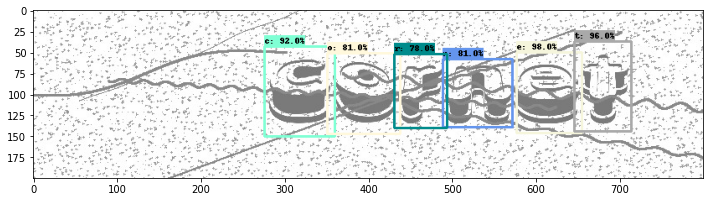

In [0]:
startTime = datetime.now()

image_path = "/content/tensorflow-object-detection-faster-rcnn/images/test/cornet.jpg"
print (image_path)
process_one_image(image_path)

print ("##### Duration: ", datetime.now() - startTime)

This captcha says: angledb
This captcha says: nirls
This captcha says: bllees
##### Duration:  0:00:11.652092


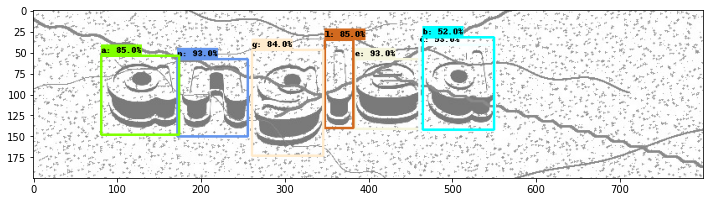

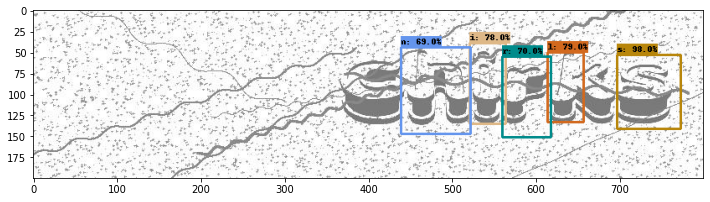

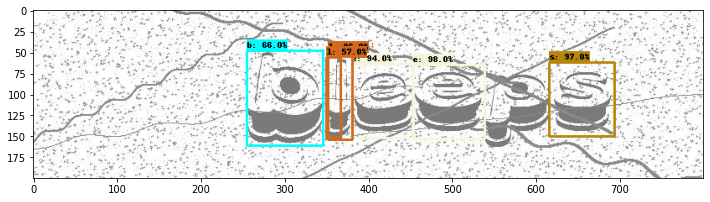

In [0]:
startTime = datetime.now()

start_counter = 0
images_to_show = 3

for image_path in TEST_IMAGE_PATHS:
  if ".jpg" in image_path:
    if start_counter < images_to_show :
      image = Image.open(image_path)
      process_one_image(image_path)
      start_counter = start_counter + 1


print ("##### Duration: ", datetime.now() - startTime)     